In [1]:
import torch 
import torch.nn as nn
# import torch.nn.init as init
import matplotlib.pyplot as plt
import time
import torch.optim as optim
import torch.utils.data as data

import sys
import numpy as np
from scipy.stats import levy_stable
import datetime
from torch.utils.checkpoint import checkpoint

from scipy import optimize
from scipy import integrate


%load_ext autoreload
%autoreload 2

In [2]:
# notebook parameters
random_seed = 1
step_size = 0.5  
n_pts = 50000      # number of points
alpha = 1.5

n_x=50 #number of different x

#n_layers = 2
n_hidden_dim = 25

n_input_dim = 1
n_output_dim = 1 

BATCH_SIZE = 512


def setup_seed(seed):
    torch.manual_seed(seed)
    #torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    # random.seed(seed)
    #torch.backends.cudnn.deterministic = True

In [3]:
# added: data generation 
setup_seed(random_seed)
class SDEIntegrators:
    """
    Implements the common Euler-Maruyama 
    scheme used in integration of SDE.
    """

    def __init__(self):
        pass

    
    @staticmethod
    def euler_maruyama(xn, h, _f_sigma, rng):

        dL = levy_stable.rvs(alpha=alpha, beta=0, size=xn.shape, scale=h**(1/alpha))    # added for levy 
        
        xk = xn.reshape(1, -1)  # we only allow a single point as input

        fk, sk = _f_sigma(xk)
        if np.prod(sk.shape) == xk.shape[-1]:
            skL = sk * dL  
        else:
            sk = sk.reshape(xk.shape[-1], xk.shape[-1])
            skL = ((sk @ dL.T).T)

        return xk + h * fk + skL   # added for levy 

    
def sample_data(drift_diffusivity, step_size, n_dimensions, low, high, n_pts, rng, n_subsample=1): 
    x_data = np.linspace(low, high, n_x+1)
    x_data = np.repeat(x_data[:-1],n_pts/n_x).reshape(-1,n_dimensions)
    y_data = x_data.copy()
    for k in range(n_subsample):
        y_data = np.row_stack([
            SDEIntegrators.euler_maruyama(y_data[k, :],
                                          step_size / n_subsample,
                                          drift_diffusivity,
                                          rng)
            for k in range(x_data.shape[0])
        ])

    return x_data, y_data


# EXAMPLE 1
def true_drift(x):
    return 4*x-x**3



def true_diffusivity(x):
    return 0*x*0.01+1


def true_drift_diffusivity(x):
    return true_drift(x), true_diffusivity(x)


rng = np.random.default_rng(random_seed)

x_data, y_data = sample_data(true_drift_diffusivity,
                             step_size=step_size, n_dimensions=n_input_dim,
                             low=-2.5, high=2.5, n_pts=n_pts,
                             rng=rng)
print('data shape', x_data.shape)

#trick
y_mean = np.array([])
y_median = np.array([])
x_mean = np.array([])
for i in range(n_x):
    yi_mean = np.mean(y_data[(i*np.int(n_pts/n_x)):((i+1)*np.int(n_pts/n_x)),0])
    yi_median = np.median(y_data[(i*np.int(n_pts/n_x)):((i+1)*np.int(n_pts/n_x)),0])
    xi_mean = x_data[i*np.int(n_pts/n_x),0]
    y_mean = np.append(y_mean, yi_mean)
    y_median = np.append(y_median, yi_median)
    x_mean = np.append(x_mean, xi_mean)

y_mean = y_mean.reshape(-1,1)
y_median = y_median.reshape(-1,1)
x_mean = x_mean.reshape(-1,1)


data shape (50000, 1)


In [4]:
#trick2

y_mean2 = np.array([])

for i in range(n_x):
    yi_mean = np.mean(np.sort(y_data.ravel()[(i*np.int(n_pts/n_x)):((i+1)*np.int(n_pts/n_x))])[400:600])
    y_mean2 = np.append(y_mean2, yi_mean)
    
y_mean2 = y_mean2.reshape(-1,1)

In [5]:
#network initialization
small_init=1e-2
def weight_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias,0.1)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
    elif isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight.data,-small_init,small_init)
        nn.init.uniform_(m.bias,-small_init,small_init)

In [6]:
#network structure
class FCNN1(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim):
        super(FCNN1,self).__init__()
        self.hidden1 = nn.Linear(in_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.hidden3 = nn.Linear(hidden_dim, hidden_dim)
        self.predict = nn.Linear(hidden_dim, out_dim)
    def forward(self,input):
        out = self.hidden1(input)
        out = torch.nn.functional.elu(out)
        out = self.hidden2(out)
        out = torch.nn.functional.elu(out)
        out = self.hidden3(out)
        out = torch.nn.functional.elu(out)
        out = self.predict(out)

        return out
    
class FCNN2(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim):
        super(FCNN2,self).__init__()
        self.hidden1 = nn.Linear(in_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.predict = nn.Linear(hidden_dim, out_dim)
    def forward(self,input):
        out = self.hidden1(input)
        out = torch.nn.functional.elu(out)
        out = self.hidden2(out)
        out = torch.nn.functional.elu(out)
        out = self.predict(out)
        out = torch.nn.functional.softplus(out) + torch.tensor([1e-13])

        return out



In [7]:
# ms_model = FCNN(n_input_dim, n_output_dim, n_hidden_dim)
mean_model = FCNN1(n_input_dim, n_output_dim, n_hidden_dim)
std_model = FCNN2(n_input_dim, n_output_dim, n_hidden_dim)

# weight_init(ms_model)
weight_init(std_model)

# optimizer = optim.Adamax(ms_model.parameters(), lr=0.005,eps=1e-07)
optimizer1 = optim.Adam(mean_model.parameters(), lr=0.005)
optimizer2 = optim.Adamax(std_model.parameters(),lr=0.005, eps=1e-07)
#optimizer2 = optim.Adamax(std_model.parameters(),lr=0.001, eps=1e-07)
#mean_model,std_model

In [8]:
#S0(alpha,beta,sigmma,gamma),beta=0,sigmma=1,gamma=0 in numpy
import math
def pdf_zolotarev(x, alpha=alpha):
    """Calculate pdf using Zolotarev's methods as detailed in [BS].
    """
    
    if alpha != 1:
        x0 = x   # convert to S_0 parameterization
        
        def V(theta):
            return (np.cos(theta)/np.sin(alpha*theta))**(alpha/(alpha-1)) * \
                    (np.cos((alpha-1)*theta)/np.cos(theta))
        if x0 > 0:
            def g(theta):
                return (V(theta) *
                        np.real(np.complex128(x0)**(alpha/(alpha-1))))

            def f(theta):
                return g(theta) * np.exp(-g(theta))

            # spare calculating integral on null set
            # use isclose as macos has fp differences

            with np.errstate(all="ignore"):
                intg_max = optimize.minimize_scalar(lambda theta: -f(theta), bounds=[0, np.pi/2])
                intg_kwargs = {}
                # windows quadpack less forgiving with points out of bounds
                if intg_max.success and not np.isnan(intg_max.fun)\
                        and intg_max.x > 0 and intg_max.x < np.pi/2:
                    intg_kwargs["points"] = [intg_max.x]
                intg = integrate.quad(f, 0, np.pi/2, **intg_kwargs)[0]
                return alpha * intg / np.pi / np.abs(alpha-1) / x0
        elif x0 == 0:
            return math.gamma(1+1/alpha)/np.pi
        else:
            return pdf_zolotarev(-x, alpha)
r=pdf_zolotarev(1);r

0.20203815960784008

In [9]:
#S0(alpha,beta,sigmma,gamma),beta=0,sigmma=1,gamma=0 in torch
import math
def pdf_zolotarev2(x0, alpha=alpha):
    """Calculate pdf using Zolotarev's methods as detailed in [BS].
    """
    small_value = torch.Tensor([1e-8])
    
    if alpha != 1:
        #x0 = x   # convert to S_0 parameterization
        #x0 = torch.tensor([x], dtype=torch.float32, requires_grad=True)
        def V(theta):
            if alpha > 1:
                if torch.sin(alpha*theta) == 0 or torch.cos(theta) == 0:
                    return (torch.cos(theta)/(torch.sin(alpha*theta) + small_value))**(alpha/(alpha-1)) * \
                            (torch.cos((alpha-1)*theta)/(torch.cos(theta) + small_value))
                else:
                    return (torch.cos(theta)/torch.sin(alpha*theta))**(alpha/(alpha-1)) * \
                            (torch.cos((alpha-1)*theta)/torch.cos(theta))
            else:
                if theta == torch.tensor([np.pi/2]):
                    return ((torch.cos(theta)+small_value)/torch.sin(alpha*theta))**(alpha/(alpha-1)) * \
                            (torch.cos((alpha-1)*theta)/(torch.cos(theta)+small_value))
                else:
                    return (torch.cos(theta)/torch.sin(alpha*theta))**(alpha/(alpha-1)) * \
                            (torch.cos((alpha-1)*theta)/torch.cos(theta))
        if x0 > 0:
            def g(theta):
                return (V(theta) * x0 **(alpha/(alpha-1)))
#                         torch.real(torch.complex(x0,torch.Tensor([0.]))**(alpha/(alpha-1))))

            def f(theta):
                return g(theta) * torch.exp(-g(theta))

            # spare calculating integral on null set
            # use isclose as macos has fp differences
            intg_n = 100 
            theta = torch.linspace(0., np.pi/2, intg_n+1)
            ff = torch.zeros_like(theta, dtype=torch.float32)
            for i in range(theta.shape[0]):
                ff[i] = f(theta[i])
        
#             fnotnan = ff>=0
#             fnan =~fnotnan
#             ff = torch.where(fnan, torch.zeros_like(ff,dtype=torch.float32), ff)
            intg = 0
            for i in range(intg_n):
                intg += (ff[i + 1] + ff[i]) * (theta[1] - theta[0]) / 2

            
            return alpha * intg / np.pi / np.abs((alpha-1))/ x0
        elif x0 == 0:
            return torch.Tensor([math.gamma(1+1/alpha)/np.pi]) + 0*x0
        else:
            return pdf_zolotarev2(-x0, alpha)
        
t=torch.tensor([1.],requires_grad=True)
r=pdf_zolotarev2(t);r.backward()
print(r,t.grad)
#r=pdf_zolotarev2(69814);r

tensor([0.2020], grad_fn=<DivBackward0>) tensor([-0.1356])


In [10]:
#S_alpha(h**(1/alpha)*sigma(x),0,x+f(x)*h) pdf
def alpha_stable_pdf(yn, ynp1, step_size_, drift_, diffusivity_, alpha=alpha):
    
    f_alpha = torch.zeros_like(torch.Tensor(yn))
    ynp1_std = ((ynp1-yn-step_size_*drift_)/(step_size_**(1/alpha)*diffusivity_))
    for k in range(yn.shape[0]):
        f_alpha[k] = pdf_zolotarev2(ynp1_std[k])


    return f_alpha/(step_size_**(1/alpha)*diffusivity_)

In [11]:
#different loss
def log_prob_loss(mean, std, step_size, x, y):
    
    y_dist = alpha_stable_pdf(x ,y, step_size, mean.reshape(-1,1), std.reshape(-1,1))
    y_log_prob = -torch.log(y_dist)
    return y_log_prob

def abs_loss(mean, std, step_size, x, y):
    dL = levy_stable.rvs(alpha=alpha, beta=0, size=x.shape, scale=step_size**(1/alpha))
    absloss = torch.abs(y - (x + mean.reshape(-1,1) * step_size + std.reshape(-1,1) * torch.Tensor(dL)))
    
    return absloss

def square_loss(mean, step_size, x, y):
#     dL = levy_stable.rvs(alpha=alpha, beta=0, size=x.shape, scale=step_size**(1/alpha))
    absloss = torch.square(y - (x + mean.reshape(-1,1) * step_size))# + std.reshape(-1,1) * torch.Tensor(dL)))
    
    return absloss


epoch: 1 Loss: tensor(1.4119, grad_fn=<MeanBackward0>)
tensor([[-2.2496e-01],
        [-2.1851e-01],
        [-2.1172e-01],
        [-2.0457e-01],
        [-1.9705e-01],
        [-1.8913e-01],
        [-1.8078e-01],
        [-1.7199e-01],
        [-1.6271e-01],
        [-1.5293e-01],
        [-1.4259e-01],
        [-1.3164e-01],
        [-1.2005e-01],
        [-1.0777e-01],
        [-9.4803e-02],
        [-8.1088e-02],
        [-6.6569e-02],
        [-5.1193e-02],
        [-3.4914e-02],
        [-1.7673e-02],
        [ 5.1989e-04],
        [ 1.9703e-02],
        [ 3.9745e-02],
        [ 6.0580e-02],
        [ 8.2169e-02],
        [ 1.0446e-01],
        [ 1.2705e-01],
        [ 1.4978e-01],
        [ 1.7263e-01],
        [ 1.9550e-01],
        [ 2.1832e-01],
        [ 2.4101e-01],
        [ 2.6356e-01],
        [ 2.8580e-01],
        [ 3.0767e-01],
        [ 3.2911e-01],
        [ 3.4998e-01],
        [ 3.7032e-01],
        [ 3.9020e-01],
        [ 4.0964e-01],
        [ 4.2859e-01],
  

epoch: 62 Loss: tensor(0.0313, grad_fn=<MeanBackward0>)
tensor([[ 5.3802],
        [ 4.3122],
        [ 3.2645],
        [ 2.2445],
        [ 1.2579],
        [ 0.3352],
        [-0.5093],
        [-1.2630],
        [-1.9229],
        [-2.4816],
        [-2.9250],
        [-3.2428],
        [-3.4343],
        [-3.4969],
        [-3.4532],
        [-3.3316],
        [-3.1495],
        [-2.9188],
        [-2.6432],
        [-2.3262],
        [-1.9783],
        [-1.6057],
        [-1.2082],
        [-0.7949],
        [-0.3648],
        [ 0.0783],
        [ 0.5206],
        [ 0.9622],
        [ 1.4016],
        [ 1.8346],
        [ 2.2324],
        [ 2.5889],
        [ 2.9065],
        [ 3.1680],
        [ 3.3564],
        [ 3.4451],
        [ 3.4395],
        [ 3.3388],
        [ 3.1448],
        [ 2.8634],
        [ 2.4997],
        [ 2.0517],
        [ 1.5116],
        [ 0.8701],
        [ 0.1584],
        [-0.5797],
        [-1.3357],
        [-2.1062],
        [-2.8884],
        [-3.6

epoch: 124 Loss: tensor(0.0014, grad_fn=<MeanBackward0>)
tensor([[ 5.4560e+00],
        [ 4.2186e+00],
        [ 3.0122e+00],
        [ 1.8827e+00],
        [ 8.8202e-01],
        [ 1.4235e-02],
        [-7.2332e-01],
        [-1.3451e+00],
        [-1.8694e+00],
        [-2.2924e+00],
        [-2.6163e+00],
        [-2.8686e+00],
        [-3.0502e+00],
        [-3.1424e+00],
        [-3.1511e+00],
        [-3.0820e+00],
        [-2.9436e+00],
        [-2.7491e+00],
        [-2.5045e+00],
        [-2.2141e+00],
        [-1.8858e+00],
        [-1.5373e+00],
        [-1.1725e+00],
        [-7.9167e-01],
        [-3.9784e-01],
        [ 2.9386e-03],
        [ 3.9680e-01],
        [ 7.8401e-01],
        [ 1.1663e+00],
        [ 1.5377e+00],
        [ 1.8708e+00],
        [ 2.1656e+00],
        [ 2.4250e+00],
        [ 2.6508e+00],
        [ 2.8423e+00],
        [ 2.9834e+00],
        [ 3.0685e+00],
        [ 3.0931e+00],
        [ 3.0238e+00],
        [ 2.8541e+00],
        [ 2.5917e+00],


epoch: 189 Loss: tensor(0.0012, grad_fn=<MeanBackward0>)
tensor([[ 5.4903],
        [ 4.1976],
        [ 2.9397],
        [ 1.7986],
        [ 0.8101],
        [-0.0443],
        [-0.7728],
        [-1.3917],
        [-1.9122],
        [-2.3270],
        [-2.6518],
        [-2.9066],
        [-3.0846],
        [-3.1732],
        [-3.1796],
        [-3.1096],
        [-2.9723],
        [-2.7807],
        [-2.5400],
        [-2.2542],
        [-1.9260],
        [-1.5726],
        [-1.2035],
        [-0.8196],
        [-0.4237],
        [-0.0217],
        [ 0.3736],
        [ 0.7649],
        [ 1.1535],
        [ 1.5307],
        [ 1.8677],
        [ 2.1640],
        [ 2.4230],
        [ 2.6466],
        [ 2.8319],
        [ 2.9609],
        [ 3.0333],
        [ 3.0506],
        [ 2.9836],
        [ 2.8242],
        [ 2.5717],
        [ 2.2347],
        [ 1.8146],
        [ 1.3078],
        [ 0.7044],
        [-0.0183],
        [-0.8928],
        [-1.9292],
        [-3.0048],
        [-4.

epoch: 245 Loss: tensor(0.0009, grad_fn=<MeanBackward0>)
tensor([[ 5.6169],
        [ 4.3049],
        [ 3.0296],
        [ 1.8904],
        [ 0.9024],
        [ 0.0476],
        [-0.6822],
        [-1.3068],
        [-1.8330],
        [-2.2516],
        [-2.5801],
        [-2.8391],
        [-3.0181],
        [-3.1071],
        [-3.1134],
        [-3.0440],
        [-2.9087],
        [-2.7200],
        [-2.4826],
        [-2.2004],
        [-1.8734],
        [-1.5212],
        [-1.1541],
        [-0.7728],
        [-0.3803],
        [ 0.0180],
        [ 0.4118],
        [ 0.8035],
        [ 1.1918],
        [ 1.5697],
        [ 1.9078],
        [ 2.2044],
        [ 2.4630],
        [ 2.6855],
        [ 2.8677],
        [ 2.9918],
        [ 3.0598],
        [ 3.0710],
        [ 2.9976],
        [ 2.8367],
        [ 2.5863],
        [ 2.2521],
        [ 1.8353],
        [ 1.3322],
        [ 0.7324],
        [ 0.0129],
        [-0.8601],
        [-1.9048],
        [-2.9927],
        [-4.

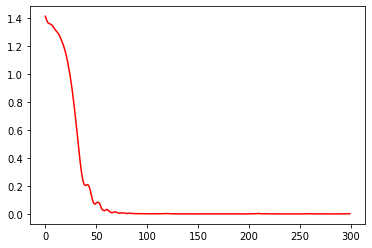

Time used: 1.1312667000000012


In [12]:
#step1
tis1 = time.perf_counter()    
epoch = 300


Loss = np.array([])

x_mean1, y_mean1 = torch.from_numpy(x_mean).float(), torch.from_numpy(y_mean2).float()
train_dataset = data.TensorDataset(x_mean1, y_mean1)


loader = data.DataLoader(
    dataset=train_dataset,
    batch_size=1000000,
    shuffle=True
    )

for i in range(epoch):    # 对整套数据训练iterations次
    for step, (batch_x, batch_y) in enumerate(loader):
        
        optimizer1.zero_grad()
        #optimizer2.zero_grad()
        approx_mean = mean_model((batch_x))[:, 0]
#         approx_std = ms_model((batch_x))[:, 1]
#         log_prob = log_prob_loss(approx_mean, step_size, batch_x, batch_y)
        absloss = square_loss(approx_mean, step_size, batch_x, batch_y)
        loss = torch.mean(absloss)#+absloss)
        loss.backward()
        optimizer1.step()
        #optimizer2.step()
        Loss = np.append(Loss, loss.detach().numpy())
        torch.cuda.empty_cache()
        #print("step:", i+1, "Loss:", loss)
    print("epoch:",i+1, "Loss:", loss)
    print(mean_model(torch.Tensor(x_mean)))
    
## Plotting the loss function
q=np.arange(0,len(Loss))
plt.plot(q,Loss,'r')
plt.show()

tis2 = time.perf_counter()
print("Time used:", tis2-tis1)

In [13]:
#step2:
tis1 = time.perf_counter()    
epoch = 9  ### Epoch=9


Loss = np.array([])

x_data1, y_data1 = torch.from_numpy(x_data).float(), torch.from_numpy(y_data).float()
train_dataset = data.TensorDataset(x_data1, y_data1)


loader = data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
    )

for i in range(epoch):    # 对整套数据训练iterations次
    for step, (batch_x, batch_y) in enumerate(loader):
        
#         optimizer.zero_grad()
        optimizer2.zero_grad()
        approx_mean = mean_model((batch_x))[:, 0]
        approx_std = std_model((batch_x))[:, 0]
        log_prob = log_prob_loss(approx_mean, approx_std, step_size, batch_x, batch_y)
#         absloss = abs_loss(approx_mean, approx_std, step_size, batch_x, batch_y)
        loss = torch.mean(log_prob)#+absloss)
        loss.backward()
        optimizer2.step()
        #optimizer2.step()
        Loss = np.append(Loss, loss.detach().numpy())
        torch.cuda.empty_cache()
        #print("step:", i+1, "Loss:", loss)
    print("epoch:",i+1, "Loss:", loss)
    print(std_model(torch.Tensor(x_data))[::1000])
    
## Plotting the loss function
q=np.arange(0,len(Loss))
plt.plot(q,Loss,'r')
plt.show()

tis2 = time.perf_counter()
print("Time used:", tis2-tis1)

KeyboardInterrupt: 

In [ ]:
#Kramers-Moyal results
nf_drift = np.array([5.21818, 3.71469, 3.27076, 2.446, 0.719385, -0.349234, 0.00116967, -1.03614, -0.81661, -2.85582, -2.2265, -2.8449, -3.07811, -4.53801, -2.97739, -3.752, -2.39683, -2.03386, -2.48156, -3.33764, -1.18298, -0.813531, -0.493239, -1.58336, 0.156019, 0.454414, -0.732734, 1.04017, 1.77175, 1.61852, 4.42377, 2.90813, 1.41911, 2.85142, 1.57699, 3.42958, 3.20394, 3.56917, 2.16438, 3.31054, 3.35102, 2.68998, 1.36955, 2.05578, 0.830427, 0.0229936, -0.993495, -1.96964, -3.07569, -4.50697])
nf_drift = np.repeat(nf_drift, n_pts/n_x)
nf_diffusivity = np.repeat(0.980972661977492, n_pts)
print(nf_drift,nf_diffusivity)

In [ ]:
def compare_plot_results_functions(mean_network, std_network, true_drift_diffusivity, nf_drift, nf_diffusivity, 
                           x_data, y_data, rng):
    

    mean_network = mean_network.detach().numpy()
    std_network = std_network.detach().numpy()

    n_dimensions = x_data.shape[1]  

    ms = 0.25  # marker size

    true_drift_evaluated, true_std_evaluated = true_drift_diffusivity(x_data)

    if n_dimensions == 1:
        mean_network = mean_network.reshape(-1, 1)
        std_network = std_network.reshape(-1, 1)
        nf_drift = nf_drift.reshape(-1, 1)
        nf_diffusivity = nf_diffusivity.reshape(-1, 1)
        
        idx_ = np.argsort(x_data.ravel()) 

        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].plot(x_data[idx_], true_drift_evaluated[idx_], "-", color="gray", label="true")
        ax[0].plot(x_data[idx_], mean_network[idx_, 0], "^", color='magenta', label="our method", markevery=len(x_data)//25)   
        ax[0].plot(x_data[idx_], nf_drift[idx_, 0], ".", color='blue', label="nonlocal Kramers-Moyal",markevery=len(x_data)//25)
        ax[0].set_xlabel("Space")
        ax[0].set_ylabel("Drift")
        ax[0].legend()

        ax[1].plot(x_data[idx_], true_std_evaluated[idx_], "-", color="gray", label="true")
        ax[1].plot(x_data[idx_], std_network[idx_, 0], "^", color='magenta', label="our method", markevery=len(x_data)//25)
        ax[1].plot(x_data[idx_], nf_diffusivity[idx_, 0], ".", color='blue', label="nonlocal Kramers-Moyal", markevery=len(x_data)//25)
        ax[1].set_xlabel("Space")
        ax[1].set_ylabel("Diffusivity")
        ax[1].legend()
        ax[1].set_ylim([0.01,2.1])
    else:
        fig, ax = plt.subplots(2, n_dimensions, figsize=(n_dimensions * 3, 6))

        for k in range(n_dimensions):
            identity_pts = np.linspace(np.min([np.min(mean_network[:, k]), np.min(true_drift_evaluated)]),
                                       np.max([np.max(mean_network[:, k]), np.max(true_drift_evaluated)]),
                                       10)

            ax[0, k].scatter(mean_network[:, k], true_drift_evaluated[:, k], s=ms, label="approximation")
            ax[0, k].plot(identity_pts, identity_pts, 'k--', label="identity")
            ax[0, k].set_xlabel(r"network drift $f_" + str(k + 1) + "$")
            ax[0, k].set_ylabel(r"true drift $f_" + str(k + 1) + "$")
            ax[0, k].legend()

            identity_pts = np.linspace(np.min([np.min(std_network[:, k]), np.min(true_std_evaluated)]),
                                       np.max([np.max(std_network[:, k]), np.max(true_std_evaluated)]),
                                       10)

            ax[1, k].scatter(std_network[:, k], true_std_evaluated[:, k], s=ms, label="approximation")
            ax[1, k].plot(identity_pts, identity_pts, 'k--', label="identity")
            ax[1, k].set_xlabel(r"network diffusivity $\sigma_" + str(k + 1) + "$")
            ax[1, k].set_ylabel(r"true diffusivity $\sigma_" + str(k + 1) + "$")
            ax[1, k].legend()
    fig.tight_layout()  
#     fig.savefig('compare_nf_mle1.eps',dpi=900,format='eps')
    return ax

In [ ]:
compare_ax = compare_plot_results_functions(estimated_ms[:,0], estimated_std[:,0], true_drift_diffusivity, nf_drift, nf_diffusivity,
                            x_data, y_data, rng)
compare_ax[1].set_ylim([0.01,2])

In [ ]:
#L2loss
L2lossf=torch.mean(torch.square(estimated_ms-torch.tensor(true_drift(x_data))))
L2lossg=torch.mean(torch.square(estimated_std-torch.tensor(true_diffusivity(x_data))))
print(L2lossf,L2lossg)

In [ ]:
#nf_loss
nf_lossf=np.mean(np.square(nf_drift.reshape(-1,1)-true_drift(x_data)));nf_lossf
nf_lossg= 1-0.98097266
print(nf_lossf,nf_lossg)